In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs

# K-Means Clustering

<IPython.core.display.Javascript object>


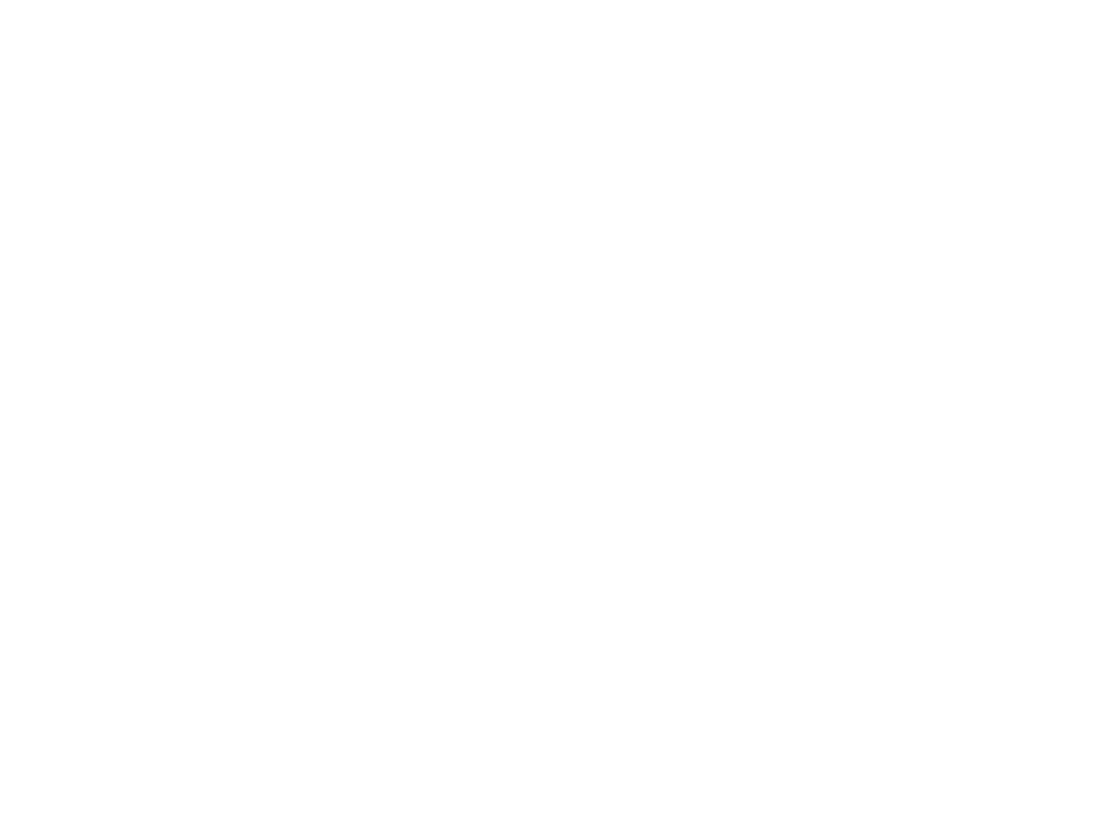

In [2]:
%matplotlib notebook
"""
X, y = make_classification(
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3
)
"""
X, y = make_blobs(n_samples=1000, centers=10, n_features=2,)
X_df = pd.DataFrame(X)
X_df.plot.scatter(x=0, y=1)

In [3]:
class KMeans(): 
    def __init__(self, k=2): 
        self.k = k 
        self.centroids = {}
        self.label = []
        
        self._fitted = False 
    
    def fit(self, X):
        self._sse_tracker = []
        # Calculating the centroids
        if len(self.centroids.keys()) == 0:
            for k in range(self.k): 
                # Choose a random point between 
                # The min and max of each feature
                self.centroids[k] = np.random.uniform(
                    X.min(axis=0), 
                    X.max(axis=0)
                )
            print("Randomly Initialising the clusters")
                
        
        while True: 
            #1. Assign each point to its closest cluster
            all_distances = []
            for k in range(self.k):
                curr_centroid = self.centroids.get(k)
                curr_distances = self.distance(X, curr_centroid)
                all_distances.append(curr_distances)
                
            # Stacking them "columnwise"
            all_distances = np.hstack([arr.reshape(-1, 1) for arr in all_distances])
            
            # 1.1 indices (columnwise) of smallest distance
            #     Returns a 1D list with indices
            self.labels = np.argmin(all_distances, axis=1)
            
            # 2. Calculate the SSE 
            curr_sse = 0
            for k in range(self.k): 
                curr_assigned_points = X[self.labels == k]
                # SSE ~ "Sum of squared distances"
                curr_squared_dist = np.sum(
                    self.distance(curr_assigned_points, self.centroids.get(k))**2
                )
                curr_sse += curr_squared_dist
            
            self.sse = curr_sse
            self._sse_tracker.append(curr_sse)
            
            print("Current SSE: {}".format(curr_sse))
            
            # 3. We have now assigned each point to each closest cluster
            #    Now we have to recalculate the new centroids
            for k in range(self.k):
                X_clusters_mapped = X[self.labels == k]
                self.centroids[k] = X_clusters_mapped.mean(axis=0)
            
            
            # 4. Define crude stopping criteria
            #diff_to_next = lambda t: [j-i for i, j in zip(t[:-1], t[1:])]
            #diff_to_next_in_arr = diff_to_next(self._sse_tracker)
            
            if len(self._sse_tracker) > 1: 
                if self._sse_tracker[-1] == self._sse_tracker[-2]: 
                    print("Reached Stopping Criteria")
                    self._fitted = True 
                    return self
                if self._sse_tracker[-1] != self._sse_tracker[-1]: 
                    raise Exception("KMeans Creating NaN in SSE-Calculation got k = {}".format(self.k))
    
    
    
    def transform(self, X):
        """Calling transfrom returns cluster labels"""
        if not self._fitted: 
            raise Exception("Not yet fitted!")
        
        all_distances = []
        for k in range(self.k):
            curr_centroid = self.centroids.get(k)
            curr_distances = self.distance(X, curr_centroid)
            all_distances.append(curr_distances)
    
        # Stacking them "columnwise"
        all_distances = np.hstack([arr.reshape(-1, 1) for arr in all_distances])
        # Indices (columnwise) of smallest distance
        # Returns a 1D list with indices
        labels = np.argmin(all_distances, axis=1)
        return labels 
            
    
    def distance(self, X, centroid):
        # calculate the root of the sum of the squared distances
        return np.sqrt(np.sum((X - centroid)**2, axis=1))


## Try Out

In [5]:
kmeans = KMeans(k = 7) # Why k > 8 leads to NaN ? 
kmeans.fit(X)

Randomly Initialising the clusters
Current SSE: 11691.736071824282
Current SSE: 6580.7980199348785
Current SSE: 4978.383209901558
Current SSE: 3214.7809338686966
Current SSE: 3038.9811035855087
Current SSE: 3010.684724543845
Current SSE: 3001.522458174035
Current SSE: 3000.1003702512285
Current SSE: 2999.9981977732714
Current SSE: 2999.9981977732714
Reached Stopping Criteria


<IPython.core.display.Javascript object>


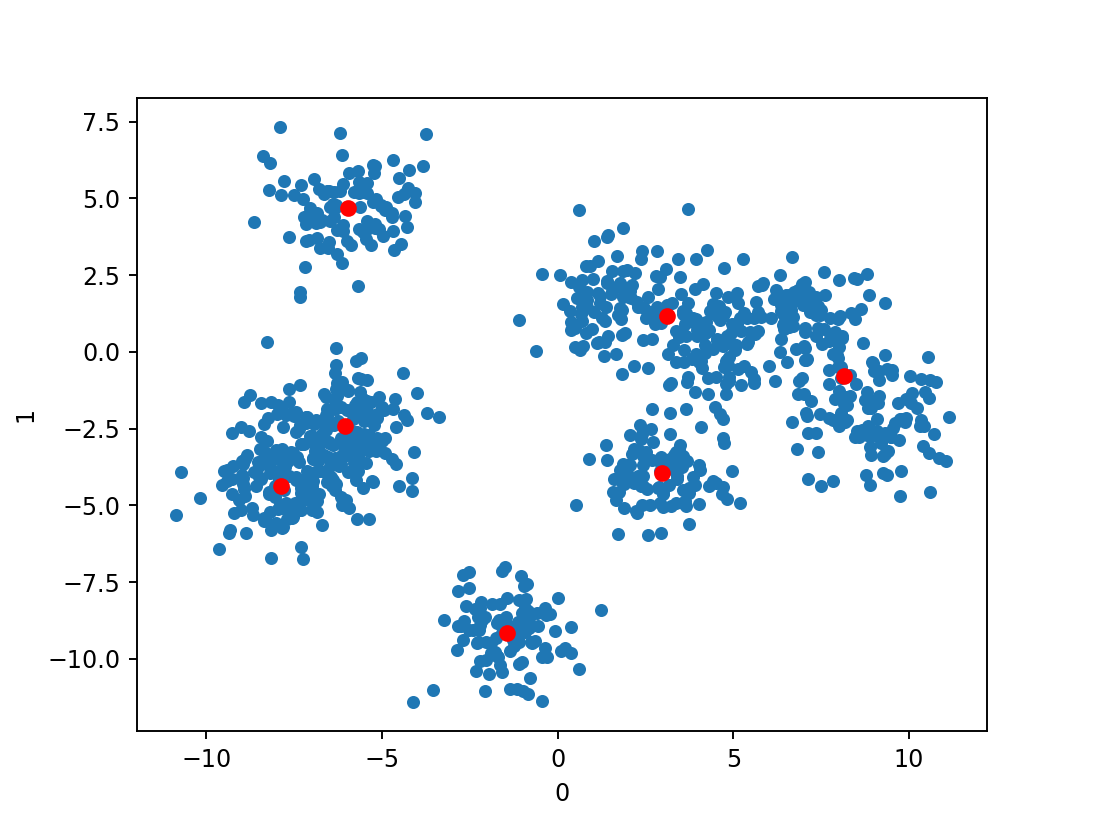

In [6]:
%matplotlib notebook 
X_df = pd.DataFrame(X)
X_df.plot.scatter(x=0, y=1)
for k,v in kmeans.centroids.items(): 
    x,y = v.tolist()
    plt.plot(x,y,'ro') 

# Gaussian Mixtures

In [71]:
class GMM(): 
    def __init__(self, j=2, early_stopping_tolerance=1e-5): 
        self.j = j        
        self.early_stopping_tolerance = early_stopping_tolerance
        
        # Internals
        self._ps_given_xs = {}
        self._fitted = False
    
    def fit(self, X): 
        """
        Arguments
        =========
        X: 2D array
            A 2D array with shape (observations, features)
        """
        assert X.ndim == 2
        
        self.centroids = {}
        self.covariances = {}
        self.mixing_coeffs = {}
        
        # Initializing random means
        init_cov = self.covariance_2D(X.T)
        for j in range(self.j): 
            # Random Points for the feasible space of all features
            self.centroids[j] = np.random.uniform(
                X.min(axis=0), 
                X.max(axis=0)
            )
            # j-Gaussians with the same covariance-matrix 
            self.covariances[j] = init_cov
            # At first all Gaussians have the same prior
            self.mixing_coeffs[j] = 1/self.j
        
        i = 0
        while True:
            i += 1
            
            #1. Calculating the posteriors
            posteriors = self.calc_posteriors(
                X=X, 
                priors = self.mixing_coeffs,
                mus = self.centroids,
                covs = self.covariances
            )
            
            self.posteriors = posteriors
                
            #2. Updating the Parameters
            new_priors, new_mus, new_covs = self.update_params(
                X = X, 
                posteriors=posteriors, 
            )
            
            total_distance = 0
            for j in range(self.j):
                total_distance += np.linalg.norm(new_mus[j] - self.centroids[j])
            
                            
            print("Distance for Iteration:\t{}\t{}".format(i, total_distance))
            
            self.centroids = new_mus
            self.mixing_coeffs = new_priors
            self.covariances = new_covs 
    
            if i > 1: 
                dist_delta = np.abs(self._last_distance - total_distance)
                if dist_delta < self.early_stopping_tolerance: 
                    print("Early Stopping on iteratio: {} due to early stopping.".format(i))
                    self._fitted = True 
                    break 
        
            self._last_distance = total_distance
    
    def predict_proba(self, X):
        if self._fitted == False: 
            raise Exception("Must fit first!")
            
        if not X.ndim == 2: 
            # Create a row vector with
            X = X.reshape(-1, 1).T
       
        posteriors = self.calc_posteriors(
            X=X, 
            priors = self.mixing_coeffs,
            mus = self.centroids,
            covs = self.covariances
        )
        
        res = []
        for j in range(self.j):
            curr_lst = []
            for i in range(len(posteriors[j].values())):
                curr_lst.append(posteriors[j][i])
        
            res.append(np.asarray(curr_lst))
        
        return np.vstack(tuple(res)).T
    
                         
    def predict(self, X): 
        res = self.predict_proba(X)
        return np.argmax(res, axis=1) 
        
    
    def update_params(self, X, posteriors): 
        # Calculating the new priors
        new_priors = {}
        for j in range(self.j): 
            if j == 0: 
                N = len(posteriors[j].values())
            new_priors[j] = sum(list(posteriors[j].values()))/N
        
        assert np.isclose(sum(new_priors.values()), 1, rtol=1e-2)
        
        self.new_priors = new_priors
        
        # Calculating the new mus
        new_mus = {}
        for j in range(self.j): 
            posterior_sum = sum(list(posteriors[j].values()))
            new_mus[j] = 0
            
            for i,x in enumerate(X):
                new_mus[j] += posteriors[j][i] * x
            new_mus[j] /= posterior_sum
        
        self.new_mus = new_mus
        
        # Calculating the new covariance matrices
        new_covs = {}
        for j in range(self.j): 
            curr_denominator = sum(list(posteriors[j].values()))
            for i,x in enumerate(X): 
                curr_posterior = posteriors[j][i]
                # individual points are 1D,
                # reshap(-1, 1) transforms them to a 2D column vector 
                mean_shifted_point = (x - new_mus[j]).reshape(-1, 1)
                # column-vector x row-vector 
                cov =  mean_shifted_point @ mean_shifted_point.T
                #print(cov.shape)
                #raise Exception("")
                if i == 0: 
                    scaled_cov = curr_posterior*cov
                else: 
                    scaled_cov += curr_posterior*cov
            
            new_covs[j] = scaled_cov/curr_denominator
        
        return new_priors, new_mus, new_covs
            
    
    def calc_posteriors(self, X, priors, mus, covs):
        """
        Arguments
        =========
        X: 2D feature matrix
            In the shape (observations, features)
        priors: Dict[Int, Int]
            A Dictionary where keys refer to the j-th cluster and the values are
            integers with priors for each cluster.
        mus: Dict[Int, 1D-Array]
            A Dictionary where every key belongs to a cluster and every value is the mean
        covs: Dict[Int, 2D-Array]
            A Dictionary where every key belongs to the covariace matrix and every value 
            is a 2D Array corresponding to a cluster j. 
        """
        p_xs_given_js = {}
        for j in range(self.j):
            curr_mu = mus[j]
            curr_cov = covs[j]
            curr_prior = priors[j]
            # For every point:
            p_xs_given_js[j] = {}
            for i, x in enumerate(X): 
                p_x_given_b = self.multivariate_gaussian_density(x, curr_mu, curr_cov)
                # Calculating the pointwise posterior probability
                p_xs_given_js[j][i] = p_x_given_b
        
        self.p_xs_given_js = p_xs_given_js
        # Calculate the Posterior Probability p(j|x) = p(x|j) * p(j)/sum()
        ## Caluclating the denominator
        
        posteriors, denominators = {}, {}
        for i,x in enumerate(X): 
            curr_denominator_sum = 0
            # The denominators for calculating the posterior
            for j in range(self.j):
                curr_denominator_sum += p_xs_given_js[j][i] * priors[j]
            
            # Calculating the posteriors
            curr_sum = 0
            for j in range(self.j):
                if i == 0: 
                    posteriors[j] = {}
                posteriors[j][i] = (p_xs_given_js[j][i] * priors[j]) / curr_denominator_sum
                curr_sum += posteriors[j][i]
            
            # The posteriors for one point should all sum 
            # to one !
            assert np.isclose(curr_sum, 1, rtol=1e-2)
        
        return posteriors
    
    @staticmethod
    def covariance_2D(X): 
        """
        Test
        ====
        for i in range(100): 
            shape = (np.random.randint(2, 10), np.random.randint(2, 10))
            X = np.random.random(shape)
            assert np.allclose(np.cov(X), covariance(X)) == True, shape
        """
        assert X.shape[0] > 1
        assert X.ndim > 1
        # each row belongs to one dimension
        # expectation can be approx. by rowwise mean
        expectation = X.mean(axis=1) 
        # subtract the expectation from each dimension
        # (X - E(X)), (Y - E(Y)), ...
        # and override X
        X -= expectation.reshape(-1, 1)
        # Multiply all entries (columnwise) and sum them up
        # This is the same as calculating the dot-product
        out = (X @ X.T) / (X.shape[1] - 1 if X.shape[1] > 1 else 1)
        return out
    
    
    @staticmethod
    def multivariate_gaussian_density(x, mu, cov):
        """
        Methodology: 
        Calculate the conditional probability of x given mu and cov:
        p(x | mu; cov)
        Arguments
        =========
        x: 1D array
            E.g. for the bivariate case: np.array([4, 1])
        mu: 1D array
            E.g. np.array([ 2.77555756e-18, -9.99200722e-18])
        cov: 2D array
            The 2D covariance with shape (2,2) for the bivariate case
            [[ 0.58321875 -0.22111271]
             [-0.22111271  0.69203907]]
        """
        assert x.ndim == mu.ndim == 1
        assert cov.shape == (x.shape[0], x.shape[0])
        size = x.shape[0]
        det = np.linalg.det(cov)
        norm_const = 1.0 / ((2 * np.pi)**(size / 2) * det ** (1.0 / 2))
        x_mu = x - mu
        inv = np.linalg.inv(cov)
        result = np.e**(-(1.0 / 2) * (x_mu @ inv @ x_mu.T))
        p_x_given_phi = norm_const * result
        return p_x_given_phi

In [40]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, 
    centers=centers, 
    cluster_std=0.4,
    random_state=0
)

In [72]:
gmm = GMM(j=3)
gmm.fit(X)

Distance for Iteration:	1	2.04754919971265
Distance for Iteration:	2	0.3511446390759189
Distance for Iteration:	3	0.4286932036263811
Distance for Iteration:	4	0.4288415453050925
Distance for Iteration:	5	0.3688827476907433
Distance for Iteration:	6	0.2607559143713129
Distance for Iteration:	7	0.25445609132708286
Distance for Iteration:	8	0.2760202374125023
Distance for Iteration:	9	0.24481923885066992
Distance for Iteration:	10	0.1974460362104561
Distance for Iteration:	11	0.1540619341378161
Distance for Iteration:	12	0.08367260082213238
Distance for Iteration:	13	0.03395404231429947
Distance for Iteration:	14	0.013078224438704156
Distance for Iteration:	15	0.005258697788271513
Distance for Iteration:	16	0.0021776196023078316
Distance for Iteration:	17	0.0009137779128575167
Distance for Iteration:	18	0.00038570385400618244
Distance for Iteration:	19	0.00016323039883282787
Distance for Iteration:	20	6.915891034511063e-05
Distance for Iteration:	21	2.9316614995472146e-05
Distance for Ite

/home/alexander/mlactive/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


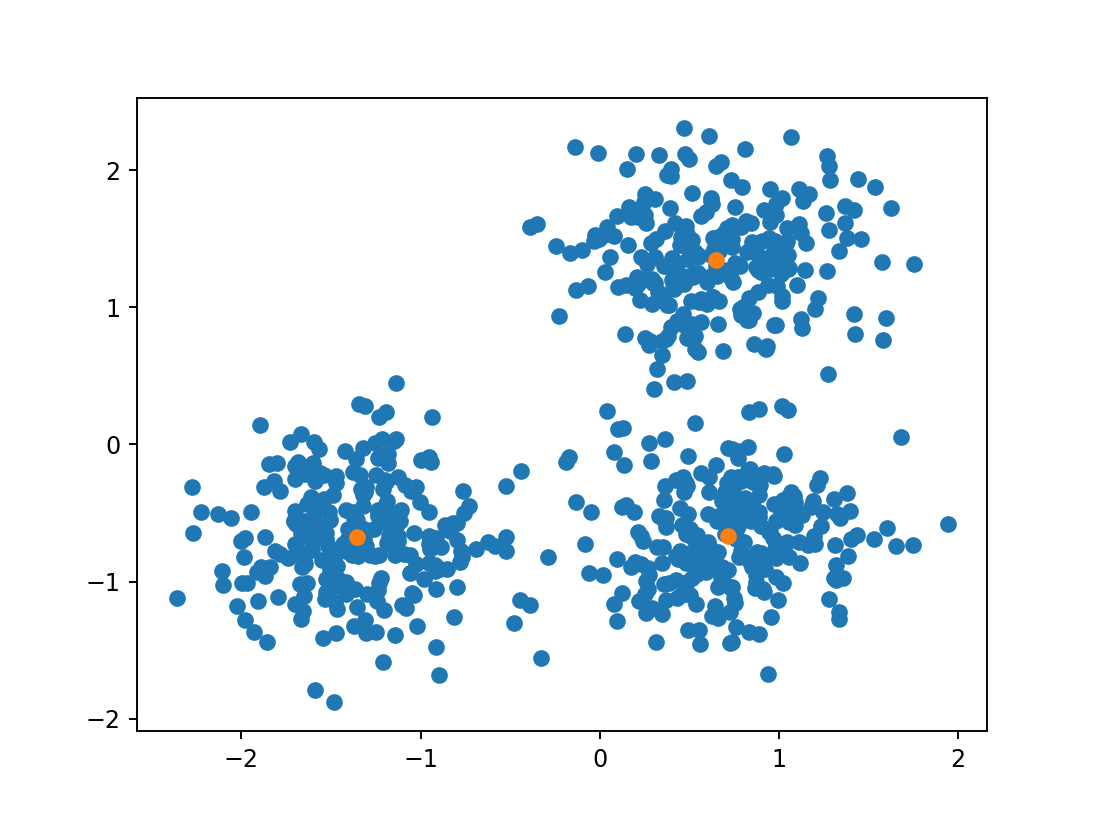

In [108]:
%matplotlib notebook 
#plt.scatter(X[:,0], X[:,1])
cents = np.vstack(gmm.centroids.values())

preds = gmm.predict(X)
probas = gmm.predict_proba(X)

    
plt.scatter(X[:,0], X[:,1])
plt.scatter(cents[:,0], cents[:,1])